# Abstract
计算Pt(100)表面Pt原子的自扩散过程的能垒，并计算应变调控的效果 

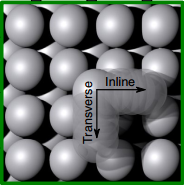

In [1]:
# packages
from atoms_model import *

import os
import numpy as np
import pandas as pd

from os import system
from os.path import join
from copy import deepcopy
import matplotlib.pyplot as plt
from genericpath import exists

from ase import Atoms
from ase.io import read
from ase.build import add_adsorbate
from ase.io.lammpsdata import write_lammps_data

In [2]:
# 设置全局字体为 Times New Roman
plt.rcParams["font.family"] = "serif"          # 使用衬线字体
plt.rcParams["font.serif"] = ["Times New Roman"]  # 指定 Times New Roman

plt.rcParams["mathtext.fontset"] = "custom"
plt.rcParams["mathtext.rm"] = "Times New Roman"
plt.rcParams["mathtext.it"] = "Times New Roman:italic"
plt.rcParams["mathtext.bf"] = "Times New Roman:bold"

In [3]:
savepath = '/media/zwbai/DATA/strain/Pt_Pt' # 保存路径根目录
input = join(savepath, 'input') # 输入目录
output = join(savepath, 'output') # 输出目录
mdpath = join(savepath, 'md_reaxff') # 输出目录
create_folder(savepath, is_delete=False)
create_folder(input, is_delete=False)
create_folder(output, is_delete=False)
create_folder(mdpath, is_delete=False)

folder /media/zwbai/DATA/strain/Pt_Pt exists
folder /media/zwbai/DATA/strain/Pt_Pt/input exists
folder /media/zwbai/DATA/strain/Pt_Pt/output exists
folder /media/zwbai/DATA/strain/Pt_Pt/md_reaxff exists


# Model

## Pt Bulk and slab

In [4]:
Pt_bulk_path = join(input,'Pt_bulk_origin')
if os.path.exists(join(input,'Pt_bulk_origin')):
    Pt_bulk = read_one_car(join(input,'Pt_bulk_origin')) # 读取Pt_bulk数据并重复三次
    lattice = Pt_bulk.get_cell()[-1,-1]
else:
    lattice = 3.97 # 默认Pt晶格常数
lattice # 获得DFT计算的Pt晶格常数

3.967271975756752

In [5]:
# 创建Pt111slab模型
recreate = False  # 是否重复Pt_bulk
filename = join(input, 'Pt.cfg')
if not exists(filename):
    print( f'File dose not exist: {filename}' )
    recreate = True
if recreate:
    try:
        del_file(filename)
        handle_line = f'atomsk --create fcc {lattice} Pt orient [110] [-110] [001] {filename}'
        print(handle_line)
        system(handle_line)
    except:
        print('atomsk is uninstall: websit\n atomsk.univ-lille.fr')

Pt_bulk = read(filename)
print(Pt_bulk.get_cell())
out_poscar(Pt_bulk, join(output, 'Pt_bulk'))  # 输出POSCAR文件

Cell([2.80528492, 2.80528492, 3.96727198])


In [6]:
Pt_bulk = read_one_car(join(input, 'Pt_bulk_copy'))  # 读取Pt_bulk数据
Pt_bulk_e = read_one_car(join(input, 'Pt_bulk_copy'), car='OSZICAR')  # 读取Pt_bulk数据
print(Pt_bulk.get_cell())

E0 value: -1 F   -.12190397E+02
Cell([2.80528492, 2.80528492, 3.96727198])


In [7]:
Pt_slab = vac_ext(Pt_bulk, vacuum_h=20.0, ads_layer=2)  # 多加2个原子并添加真空层
Pt_slab = fix_layers_atoms(Pt_slab, {(-1,-1,-1):[-1,-2], (1,1,0):[-1,-2]},)  # 固定底部2层原子
out_poscar(Pt_slab, join(output, 'Pt_slab'))  # 输出POSCAR文件

In [8]:
Pt_slab = read_one_car(join(input, 'Pt_slab_copy'))  # 读取Pt_slab数据
Pt_slab_e = read_one_car(join(input, 'Pt_slab_copy'), car='OSZICAR')  # 读取Pt_slab数据

Pt_slab = fix_layers_atoms(Pt_slab, {(-1,-1,-1):[-1,-2]})
Pt_slab = Pt_slab.repeat((4,4,1))
Pt_slab_e = Pt_slab_e*4*4

E0 value: -1 F   -.22587093E+02


# Pt self diffusion

## Pt adsorption

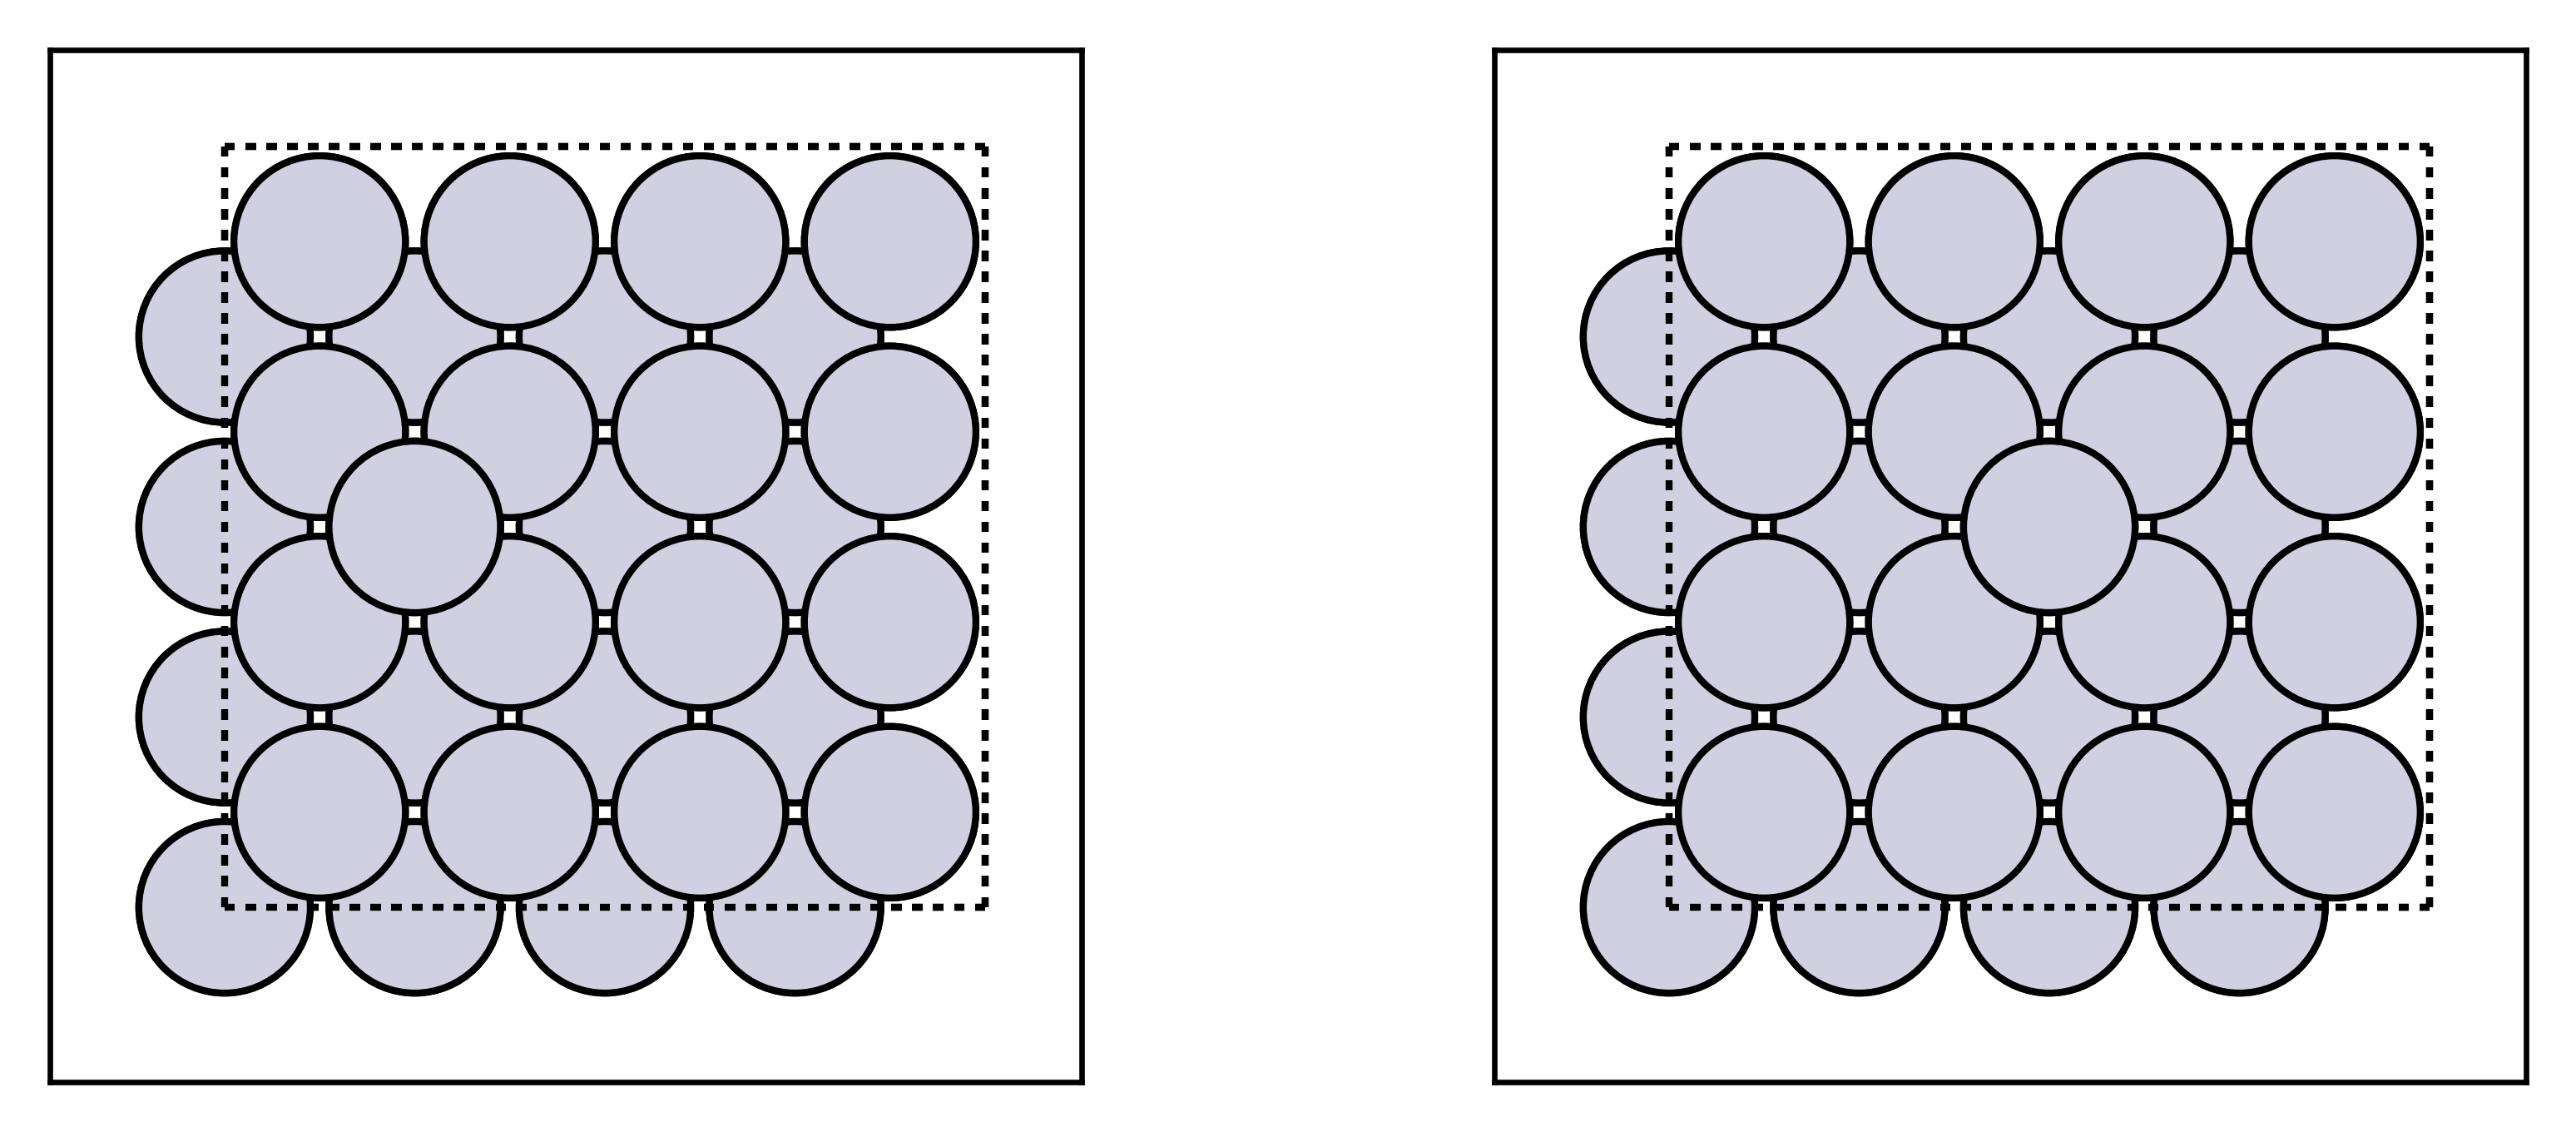

In [9]:
from sympy import rad

_, pos0 = get_location(Pt_slab, [1,2,-2]) # return the atoms order and the position
_, pos1 = get_location(Pt_slab, [2,2,-2])

Pt_atom = Atoms('Pt', positions=np.zeros((1,3)))  # create the Pt atom

Pt_ads1 = Pt_slab.copy()  # The Pt atom adsorbs on Pt slab
add_adsorbate(Pt_ads1, Pt_atom, height=1.5, position=pos0[:2])

Pt_ads2 = Pt_slab.copy()  # 氧原子吸附在Pt_slab上
add_adsorbate(Pt_ads2, Pt_atom, height=1.5, position=pos1[:2])

Pt_ads = {'is':Pt_ads1, 'fs':Pt_ads2}
out_car_list(Pt_ads, join(output, 'Pt_ads'))  # 输出吸附结构
plot_top(list(Pt_ads.values()), column=2, radii=0.93)

1st dict_keys(['fs', 'is'])
E0 value: -1 F   -.36734041E+03
E0 value: -1 F   -.36734042E+03
1st dict_keys(['fs', 'is'])


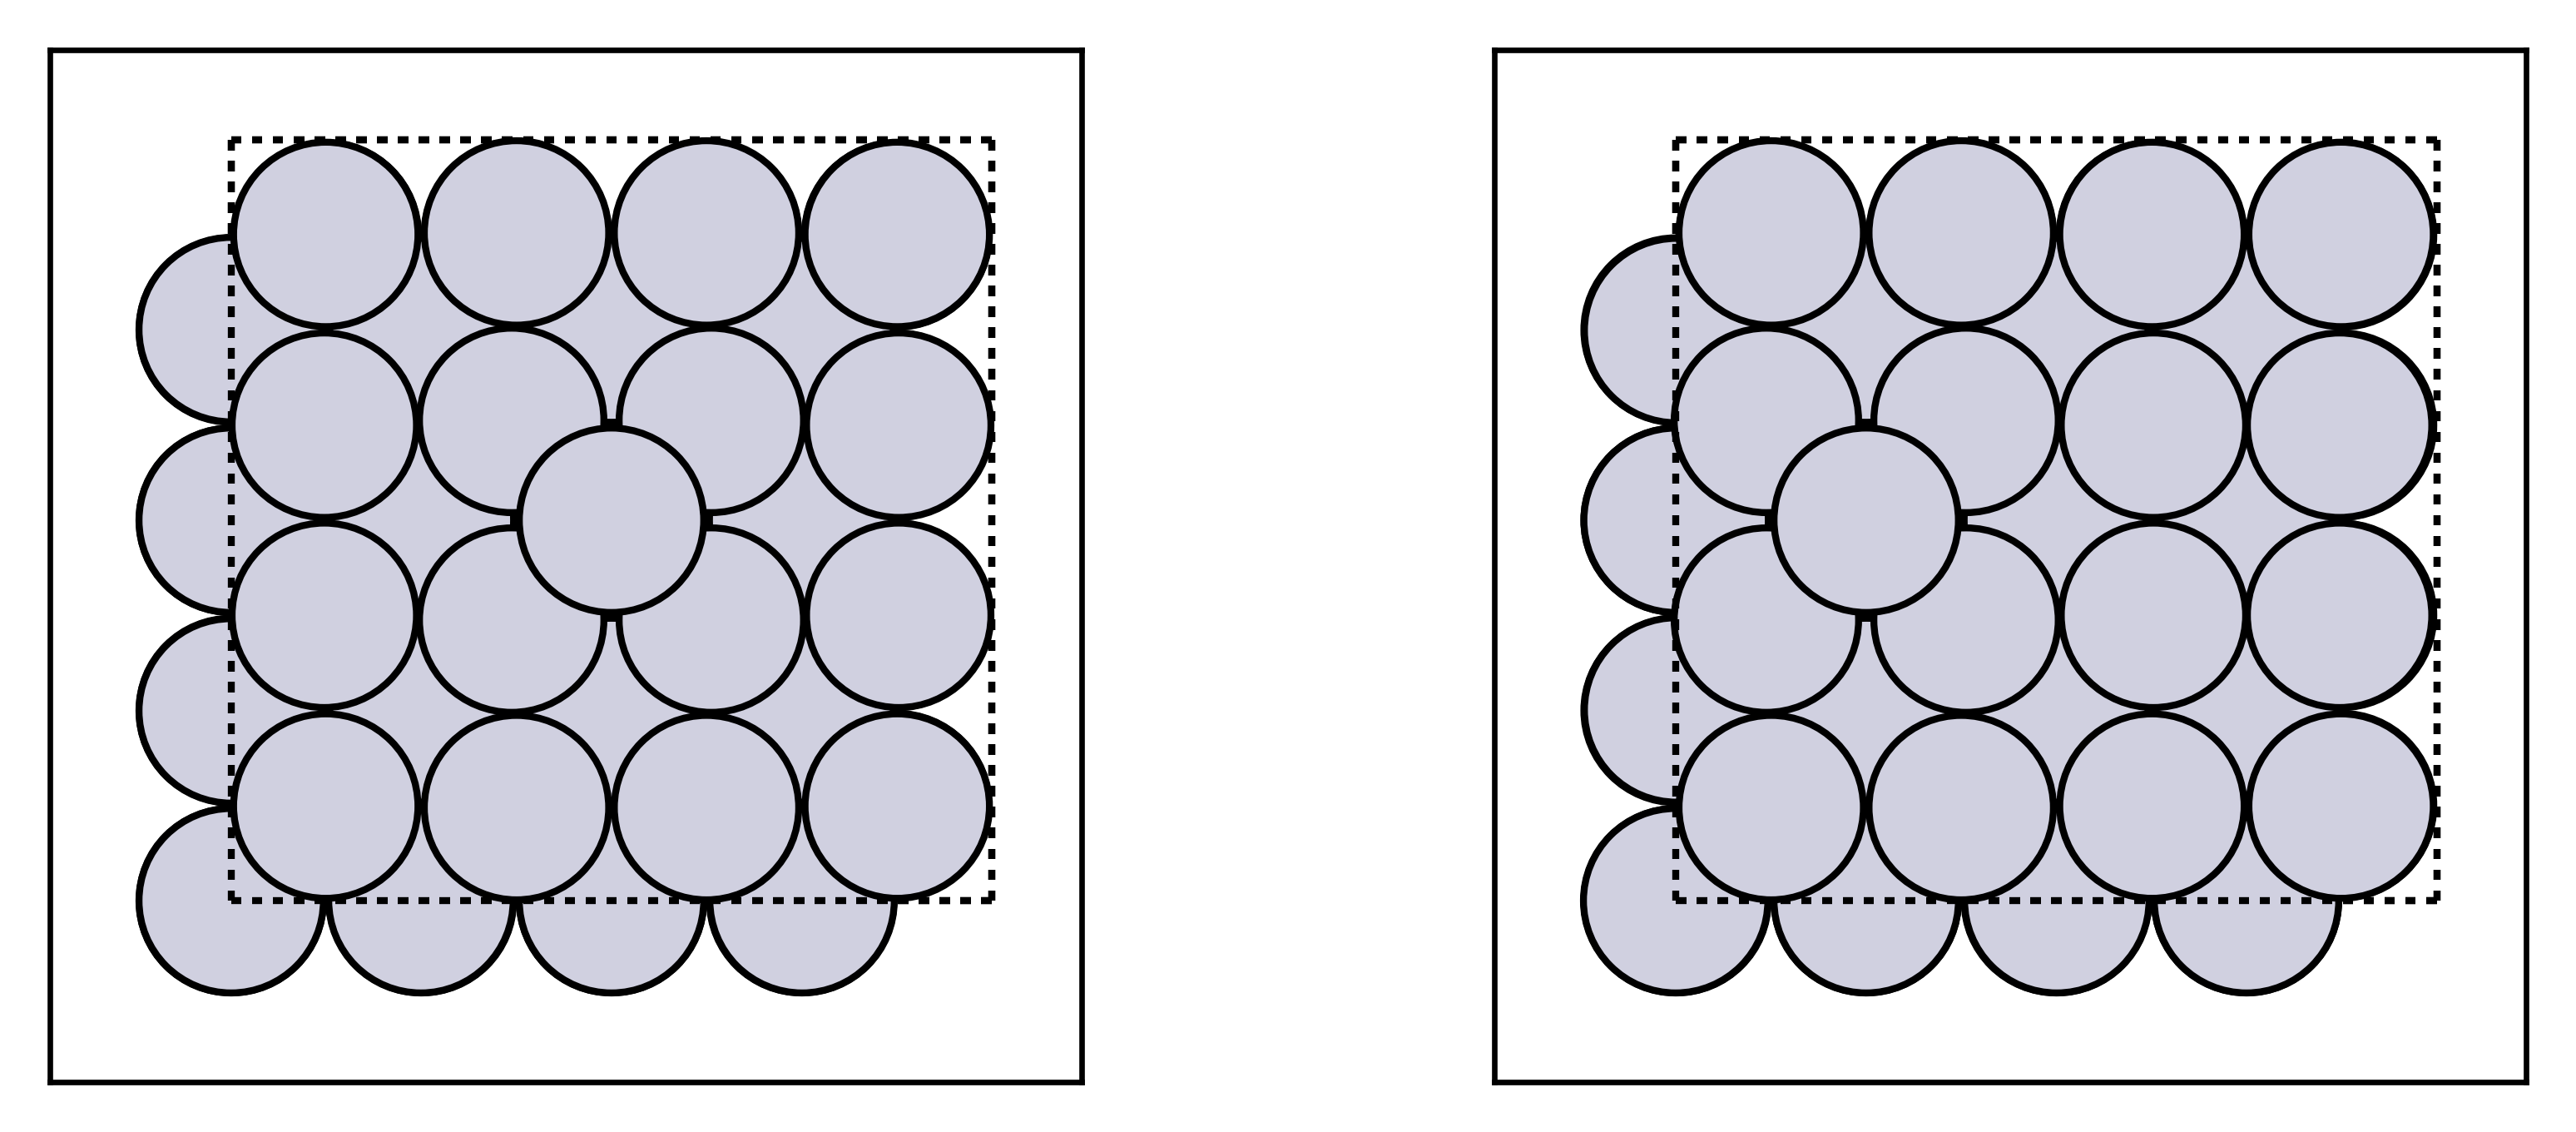

In [10]:
Pt_ads_l, Pt_ads_d = read_car(join(input, 'Pt_ads_copy'))
Pt_ads_e_l, Pt_ads_e_d = read_car(join(input, 'Pt_ads_copy'), car='OSZICAR')
plot_top(Pt_ads_d, column=2)

## NEB of O dissociation

In [11]:
ads_path =  join(input, 'Pt_ads_copy') # 存储初态和末态的地址 input_path
neb_path = join(output,'neb_Pt_diff') # 输出neb的地址 output_path
neb_l, neb_d  = create_neb(ads_path, neb_path, n_mage_prepared=1, interpolation='idpp')

True
delete /media/zwbai/DATA/strain/Pt_Pt/output/neb_Pt_diff
folder '/media/zwbai/DATA/strain/Pt_Pt/output/neb_Pt_diff' is created
/media/zwbai/DATA/strain/Pt_Pt/input/Pt_ads_copy/is
2.82079687922456
Ignore file: /media/zwbai/DATA/strain/Pt_Pt/output/neb_Pt_diff/00/POSCAR
Ignore file: /media/zwbai/DATA/strain/Pt_Pt/output/neb_Pt_diff/02/POSCAR
/media/zwbai/DATA/strain/Pt_Pt/output/neb_Pt_diff/00
/media/zwbai/DATA/strain/Pt_Pt/output/neb_Pt_diff/01
/media/zwbai/DATA/strain/Pt_Pt/output/neb_Pt_diff/02
1st dict_keys(['00', '01', '02'])


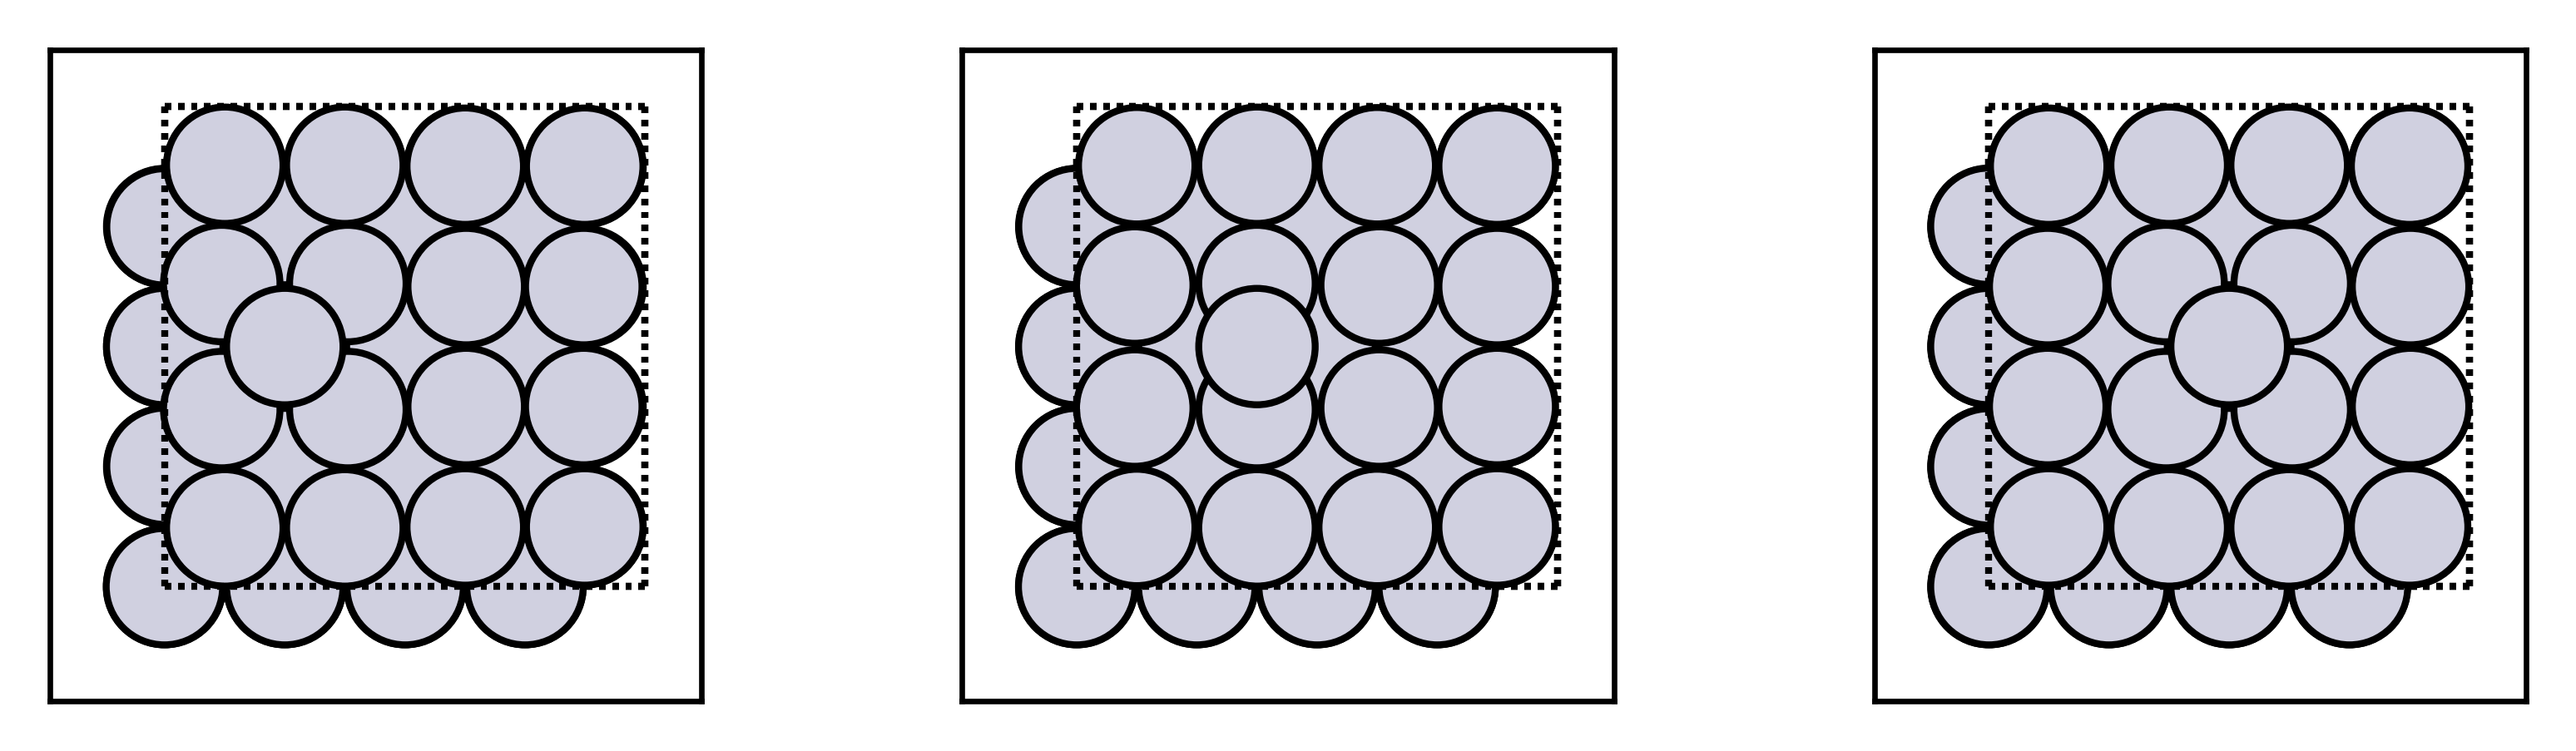

In [12]:
plot_top(neb_l)

In [13]:
neb_copy_path = join(input,'neb_Pt_diff_copy')
neb_l, neb_d = read_car(neb_copy_path)
neb_e_l, neb_e_d = read_car(neb_copy_path, car='OSZICAR')
neb_f_l, neb_f_d = read_car(neb_copy_path, car='OUTCAR')
# O_diff_f_l = np.array(O_diff_f_l).reshape(-1, 3)
neb_p  = [atoms.positions for atoms in neb_l]

1st dict_keys(['00', '01', '02'])
E0 value: -1 F   -.36734042E+03
E0 value: -1 F   -.36631972E+03
E0 value: -1 F   -.36734041E+03
1st dict_keys(['00', '01', '02'])
1st dict_keys(['00', '01', '02'])


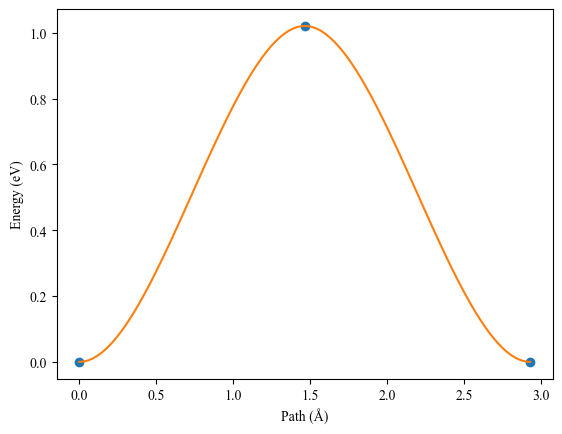

[0.00000000e+00 1.02070000e+00 9.99999997e-06]


In [14]:
dis_x = get_dist_list(neb_l)
neb_e_l = np.array(neb_e_l)
neb_e0_l = neb_e_l - neb_e_l[0]
x_interp1, y_interp1 = interpolate_plot(dis_x, neb_e0_l)
print(neb_e0_l)

In [15]:
# 用NEB的结果专门计算一个无结构优化的力场
neb_forf_d = deepcopy(neb_d)
for key,value in neb_forf_d.items():
    value_pos = value.get_positions()
    value_pos[:-1] = Pt_slab.get_positions()
    value.set_positions(value_pos)
    neb_forf_d[key] = value
neb_forf_path = join(output, 'neb_forf')
out_car_list(neb_forf_d, path=neb_forf_path)

1st dict_keys(['00', '01', '02'])


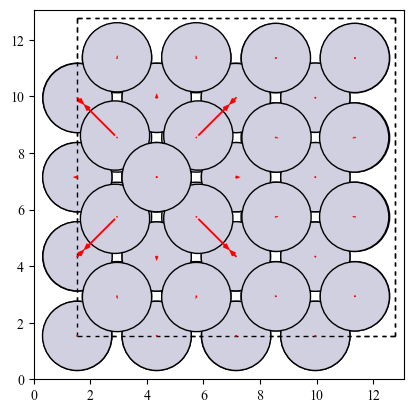

In [16]:
neb_forf_path = join(input, 'neb_forf_copy')
neb_f_l, neb_f_d = read_car(neb_forf_path, car='OUTCAR')

plot_stress(neb_l[0], neb_f_l[0])

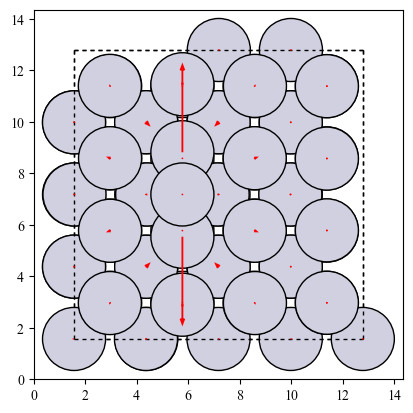

In [17]:
plot_stress(neb_l[1], neb_f_l[1])

# Strain alter Energy

## strain

In [18]:
strain_symbal_dict = {'x':[1,0,0], 'y':[0,1,0]}
# 等三轴应变，y轴应变 和 z轴应变
positive_negativate = {'p':1, 'n':-1 }
max_strain = 0.02

strain_dict = {}
for stain_key in strain_symbal_dict:
    strain_symbal = strain_symbal_dict[stain_key]
    for pn_key in positive_negativate:
        pn_value = positive_negativate[pn_key]
        strain_ = strain_symbal.copy()
        key = stain_key+'_' + pn_key
        strain_dict[key] =  np.array(strain_)*max_strain/len(stain_key)*pn_value
print(strain_dict)

# strain bulk
strain_bulk = {}
for strain_key in strain_dict:
    strain = strain_dict[strain_key]
    adslab_value = Pt_bulk.copy()
    strain_bulk[strain_key], strain_value = opt_strain_F(adslab_value, strain)

strain_bulk_path = join(output,'strain_bulk')
out_car_list(strain_bulk, path=strain_bulk_path)

{'x_p': array([0.02, 0.  , 0.  ]), 'x_n': array([-0.02, -0.  , -0.  ]), 'y_p': array([0.  , 0.02, 0.  ]), 'y_n': array([-0.  , -0.02, -0.  ])}


In [19]:
strain_bulk_copy = join(input,'strain_bulk_copy')
strain_bulk = read_car(strain_bulk_copy, car="CONTCAR")
strain_bulk_e = read_car(strain_bulk_copy, car="OSZICAR")

strain_bulk_e_d = strain_bulk_e[1]
strain_bulk_e_d['no_strain'] = Pt_bulk_e

for key, value in strain_bulk[1].items():
    s = cal_strain(Pt_bulk, value)
    print(s) # 检验应变

1st dict_keys(['x_n', 'x_p', 'y_n', 'y_p'])
E0 value: -1 F   -.12182619E+02
E0 value: -1 F   -.12186959E+02
E0 value: -1 F   -.12182619E+02
E0 value: -1 F   -.12186959E+02
1st dict_keys(['x_n', 'x_p', 'y_n', 'y_p'])
[[-0.02        0.          0.        ]
 [ 0.          0.          0.        ]
 [ 0.          0.          0.01427399]]
[[ 0.02        0.          0.        ]
 [ 0.          0.          0.        ]
 [ 0.          0.         -0.01600691]]
[[ 0.          0.          0.        ]
 [ 0.         -0.02        0.        ]
 [ 0.          0.          0.01426766]]
[[ 0.          0.          0.        ]
 [ 0.          0.02        0.        ]
 [ 0.          0.         -0.01600504]]


In [20]:
strain_slab = deepcopy(strain_bulk[1])
for key in strain_slab:
    refer_value = strain_slab[key]
    refer_value = vac_ext(refer_value, vacuum_h=20.0, ads_layer=2)  # 多加1个原子并添加真空层
    refer_value = fix_layers_atoms(refer_value, {(-1,-1,-1):[-1,-2], (1,1,0):[-1,-2]},)
    strain_slab[key] = refer_value # 固定底部2层原子
out_car_list(strain_slab, path=os.path.join(output,'strain_slab'))

In [21]:
_, strain_slab = read_car(os.path.join(input,'strain_slab_copy'))
for key in strain_slab:
    strain_slab[key] = fix_layers_atoms(refer_value, {(-1,-1,-1):[-1,-2]})
    strain_slab[key] = strain_slab[key].repeat((4,4,1))
_, strain_slab_e = read_car(os.path.join(input,'strain_slab_copy'), car='OSZICAR')
for key in strain_slab_e:
    strain_slab_e[key] = strain_slab_e[key]*4*4

for key, value in strain_slab.items():
    s = cal_strain(Pt_slab, value)
    print(s) # 检验应变

1st dict_keys(['x_n', 'x_p', 'y_n', 'y_p'])
E0 value: -1 F   -.22626544E+02
E0 value: -1 F   -.22525026E+02
E0 value: -1 F   -.22626563E+02
E0 value: -1 F   -.22525051E+02
1st dict_keys(['x_n', 'x_p', 'y_n', 'y_p'])
[[0.   0.   0.  ]
 [0.   0.02 0.  ]
 [0.   0.   0.  ]]
[[0.   0.   0.  ]
 [0.   0.02 0.  ]
 [0.   0.   0.  ]]
[[0.   0.   0.  ]
 [0.   0.02 0.  ]
 [0.   0.   0.  ]]
[[0.   0.   0.  ]
 [0.   0.02 0.  ]
 [0.   0.   0.  ]]


## strain alter neb

In [22]:
adslab_dict ={'is':Pt_ads_d['is'],
              'fs':Pt_ads_d['fs'],}
strain_adslab = {}
for strain_key in strain_dict:
    strain = strain_dict[strain_key]
    strain_ = {}
    for adslab_key in adslab_dict.keys():
        adslab_value = adslab_dict[adslab_key].copy()
        # strain_adslab_key = f'{strain_key}_{adslab_key}'
        refer_value, strain_value = opt_strain_F(adslab_value, strain)
        value_pos = refer_value.get_positions()
        value_pos[:-1,-1] = strain_slab[strain_key].get_positions()[:,-1]
        # 保持底部原子xy位置不变,仅调整了z坐标
        refer_value.set_positions(value_pos)
        strain_[adslab_key] = refer_value
    strain_adslab[strain_key] = strain_
    print(strain_key)
    print(strain_value)
strain_adslab_path = join(output,'strain_adslab')
out_car_list(strain_adslab, path=strain_adslab_path)

x_p
[[0.02 0.   0.  ]
 [0.   0.   0.  ]
 [0.   0.   0.  ]]
x_n
[[-0.02  0.    0.  ]
 [ 0.    0.    0.  ]
 [ 0.    0.    0.  ]]
y_p
[[0.   0.   0.  ]
 [0.   0.02 0.  ]
 [0.   0.   0.  ]]
y_n
[[ 0.    0.    0.  ]
 [ 0.   -0.02  0.  ]
 [ 0.    0.    0.  ]]


In [23]:
strain_adslab_copy_path = join(input,'strain_adslab_copy')
strain_adslab_l, strain_adslab_d = read_cars(strain_adslab_copy_path)

/media/zwbai/DATA/strain/Pt_Pt/input/strain_adslab_copy/CONTCARS.pkl
dict_keys(['x_n', 'x_p', 'y_n', 'y_p'])


In [24]:
strain_neb_path = join(output, 'strain_neb')
for key in strain_adslab_d.keys():
    print(join(strain_adslab_copy_path, key))
    ads_path = join(strain_adslab_copy_path, key) # 存储初态和末态的地址 input_path
    neb_path = join(strain_neb_path, key) # 输出neb的地址 output_path
    neb_l_i, neb_d_i  = create_neb(ads_path, neb_path, n_mage_prepared=1, interpolation='idpp')
    refer, _ = opt_strain(neb_l[1], strain_dict[key])
    pos_refer = refer.get_positions()
    neb_d_i['01'].set_positions(pos_refer)
    out_poscar(neb_d_i['01'], join(neb_path,'01'))

/media/zwbai/DATA/strain/Pt_Pt/input/strain_adslab_copy/x_n
True
delete /media/zwbai/DATA/strain/Pt_Pt/output/strain_neb/x_n
folder '/media/zwbai/DATA/strain/Pt_Pt/output/strain_neb/x_n' is created
/media/zwbai/DATA/strain/Pt_Pt/input/strain_adslab_copy/x_n/is
2.76500904997258
Ignore file: /media/zwbai/DATA/strain/Pt_Pt/output/strain_neb/x_n/00/POSCAR
Ignore file: /media/zwbai/DATA/strain/Pt_Pt/output/strain_neb/x_n/02/POSCAR
/media/zwbai/DATA/strain/Pt_Pt/output/strain_neb/x_n/00
/media/zwbai/DATA/strain/Pt_Pt/output/strain_neb/x_n/01
/media/zwbai/DATA/strain/Pt_Pt/output/strain_neb/x_n/02
1st dict_keys(['00', '01', '02'])
/media/zwbai/DATA/strain/Pt_Pt/input/strain_adslab_copy/x_p
True
delete /media/zwbai/DATA/strain/Pt_Pt/output/strain_neb/x_p


folder '/media/zwbai/DATA/strain/Pt_Pt/output/strain_neb/x_p' is created
/media/zwbai/DATA/strain/Pt_Pt/input/strain_adslab_copy/x_p/is
2.87967552032535
Ignore file: /media/zwbai/DATA/strain/Pt_Pt/output/strain_neb/x_p/00/POSCAR
Ignore file: /media/zwbai/DATA/strain/Pt_Pt/output/strain_neb/x_p/02/POSCAR
/media/zwbai/DATA/strain/Pt_Pt/output/strain_neb/x_p/00
/media/zwbai/DATA/strain/Pt_Pt/output/strain_neb/x_p/01
/media/zwbai/DATA/strain/Pt_Pt/output/strain_neb/x_p/02
1st dict_keys(['00', '01', '02'])
/media/zwbai/DATA/strain/Pt_Pt/input/strain_adslab_copy/y_n
True
delete /media/zwbai/DATA/strain/Pt_Pt/output/strain_neb/y_n
folder '/media/zwbai/DATA/strain/Pt_Pt/output/strain_neb/y_n' is created
/media/zwbai/DATA/strain/Pt_Pt/input/strain_adslab_copy/y_n/is
2.82499908220258
Ignore file: /media/zwbai/DATA/strain/Pt_Pt/output/strain_neb/y_n/00/POSCAR
Ignore file: /media/zwbai/DATA/strain/Pt_Pt/output/strain_neb/y_n/02/POSCAR
/media/zwbai/DATA/strain/Pt_Pt/output/strain_neb/y_n/00
/media/

In [25]:
strain_neb_copy_path = join(input,'strain_neb_copy') # 输出neb的地址 output_path
strain_neb_l, strain_neb_d = read_cars(strain_neb_copy_path)
strain_neb_e_l, strain_neb_e_d = read_cars(strain_neb_copy_path, car='OSZICAR')

/media/zwbai/DATA/strain/Pt_Pt/input/strain_neb_copy/CONTCARS.pkl
dict_keys(['x_n', 'x_p', 'y_n', 'y_p'])
/media/zwbai/DATA/strain/Pt_Pt/input/strain_neb_copy/OSZICARS.pkl
dict_keys(['x_n', 'x_p', 'y_n', 'y_p'])


In [26]:
# O_e = read_one_car(join(input,'O'), car='OSZICAR')
strain_dict['no_strain'] = np.array([.0,.0,.0])
strain_slab['no_strain'] = Pt_slab
strain_slab_e['no_strain'] = Pt_slab_e
strain_neb_d['no_strain'] = neb_d
strain_neb_e_d['no_strain'] = neb_e_d
strain_neb_e_d

{'x_n': {'00': -368.0916, '01': -367.12311, '02': -368.09147},
 'x_p': {'00': -366.1695, '01': -365.09908, '02': -366.16947},
 'y_n': {'00': -368.09146, '01': -367.00508, '02': -368.09148},
 'y_p': {'00': -366.1695, '01': -365.20918, '02': -366.16946},
 'no_strain': {'00': -367.34042, '01': -366.31972, '02': -367.34041}}

In [27]:
all_neb = {}
for key in strain_dict.keys():
    print(key)
    neb_models = strain_neb_d[key]
    neb_dist = get_dist_list(list(neb_models.values()))
    neb_x = np.array([x/neb_dist[-1] for x in neb_dist])
    neb_e = list(strain_neb_e_d[key].values())
    neb_e = np.array(neb_e) - strain_slab_e[key]

    symbel, direction = key.split('_')
    if direction == 'n':
        direction = -1
    elif direction == 'p':
        direction = 1
    else:
        direction = 0
    strain_value = direction*max_strain

    neb_data = NEB_path_e(
    name=key,
    path_points=np.array(neb_x),
    energy_values=np.array(neb_e),
    models=neb_models,  # 两个模型
    strain=strain_dict[key],
    strain_value=strain_value,
    strain_symbel=symbel,
    )
    all_neb[key] = neb_data
all_neb


x_p
x_n
y_p
y_n
no_strain


{'x_p': <EnergyProfile: x_p with 3 points,3 models,  is barrier: 1.070,fs barrier: 1.070>,
 'x_n': <EnergyProfile: x_n with 3 points,3 models,  is barrier: 0.968,fs barrier: 0.968>,
 'y_p': <EnergyProfile: y_p with 3 points,3 models,  is barrier: 0.960,fs barrier: 0.960>,
 'y_n': <EnergyProfile: y_n with 3 points,3 models,  is barrier: 1.086,fs barrier: 1.086>,
 'no_strain': <EnergyProfile: no_strain with 3 points,3 models,  is barrier: 1.021,fs barrier: 1.021>}

In [28]:
E_neb = {}
for key, x_e in all_neb.items():

    x = x_e.strain_value
    e1 =  x_e.get_is_barrier()
    e2 =  x_e.get_fs_barrier()
    symbel = x_e.strain_symbel
    if symbel not in E_neb.keys() and symbel != 'no' :
        E_neb[symbel] = [[x, e1, e2]]
    elif symbel in E_neb.keys():
        E_neb[symbel].append([x, e1, e2])
    else:  # symbel == 'no' 的情况
        # 为所有已有键的值添加数据
        for k in E_neb:
            E_neb[k].append([x, e1, e2])
E_neb

{'x': [[0.02, 1.0704200000000128, 1.0703899999999749],
  [-0.02, 0.9684900000000312, 0.9683600000000183],
  [0.0, 1.0206999999999766, 1.0206900000000019]],
 'y': [[0.02, 0.9603200000000243, 0.9602800000000116],
  [-0.02, 1.0863799999999628, 1.0863999999999692],
  [0.0, 1.0206999999999766, 1.0206900000000019]]}

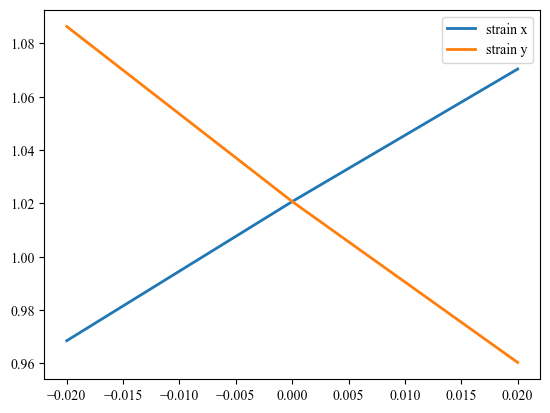

In [29]:
for key, value in E_neb.items():
    value = np.array(value)
    value = value[value[:, 0].argsort()]
    E_neb[key] = value

# 绘图
# colors = ['b', 'r']  # 假设最多两条线
for key, value in E_neb.items():
    plt.plot(value[:,0],
             value[:,1],
            #  marker='o' if idx % 2 == 0 else 's',  # 偶数索引使用圆点，奇数索引使用方块
            #  linestyle='-' if idx % 2 == 0 else '--',  # 偶数索引使用实线，奇数索引使用虚线
             linewidth = 2,
             markersize = 6,
             label=f'strain {key}')  # 根据实际情况修改标签
plt.legend()
plt.show()

# MD calculation

In [30]:
# mdpath = join(savepath, 'md_reaxff')

lattice_md = 3.9474 # 默认Pt晶格常数
# 创建Pt111slab模型
recreate = False  # 是否重复Pt_bulk

filename = join(mdpath, 'Pt_md.cfg')
if not exists(filename):
    print( f'File dose not exist: {filename}' )
    recreate = True

if recreate:
    try:
        del_file(filename)
        handle_line = f'atomsk --create fcc {lattice_md} Pt orient [110] [-110] [001] {filename}'
        print(handle_line)
        system(handle_line)
    except:
        print('atomsk is uninstall: websit\n atomsk.univ-lille.fr')
Pt_bulk_md = read(filename).repeat((12,12,6))

print(Pt_bulk_md.get_cell())
bulk_md_path = join(mdpath, 'bulk')
create_folder(bulk_md_path, is_delete=False)
filename = join(bulk_md_path,'lammps.data')
write_lammps_data(filename, Pt_bulk_md, atom_style="charge")

Cell([33.49479972, 33.49479972, 23.6844])
folder /media/zwbai/DATA/strain/Pt_Pt/md_reaxff/bulk exists


In [31]:
bulk_copy_path = join(mdpath, 'bulk_copy')
bulk_copy = read_one_car(bulk_copy_path, car=lambda x : read_lammps_onedata(x, style='charge'))
Pt_bulk_md.set_cell(bulk_copy.get_cell(), scale_atoms=True)
print(Pt_bulk_md.get_cell())

Cell([33.49425949901539, 33.49425949901539, 23.6840180060787])


In [32]:
Pt_slab_md = vac_ext(Pt_bulk_md, vacuum_h=60.0)  # 多加2个原子并添加真空层
Pt_slab_md.set_constraint()
slab_md_path = join(mdpath, 'slab')
create_folder(slab_md_path, is_delete=False)
filename = join(slab_md_path,'lammps.data')
write_lammps_data(filename, Pt_slab_md, atom_style="charge")

folder /media/zwbai/DATA/strain/Pt_Pt/md_reaxff/slab exists


In [33]:
slab_copy_path = join(mdpath, 'slab_copy')
slab_copy = read_one_car(slab_copy_path, car=lambda x : read_lammps_onedata(x, style='charge'))
slab_copy_e = read_one_car(slab_copy_path, car=extract_last_toteng)  # 提取最后一步的总能量值
Pt_slab_md.set_cell(slab_copy.get_cell(), scale_atoms=True)
slab_copy, slab_copy_e,

(Atoms(symbols='Pt1728', pbc=True, cell=[33.47695821368579, 33.47695995176755, 60.0], id=..., initial_charges=..., masses=..., mmcharges=..., momenta=..., travel=..., type=...),
 -223834.88)

In [34]:
args0, pos0 = get_location(Pt_slab_md, [5,6,-2]) # return the atoms order and the position
args1, pos1 = get_location(Pt_slab_md, [6,6,-2])

Pt_atom = Atoms('Pt', positions=np.zeros((1,3)))  # create the Pt atom

Pt_ads1 = slab_copy.copy()  # The Pt atom adsorbs on Pt slab
add_adsorbate(Pt_ads1, Pt_atom, height=1.5, position=pos0[:2])

Pt_ads2 = slab_copy.copy()  # Pt原子吸附在Pt_slab上
add_adsorbate(Pt_ads2, Pt_atom, height=1.5, position=pos1[:2])

Pt_ads = {'is':Pt_ads1, 'fs':Pt_ads2}

neb_path = join(mdpath, 'Pt_neb')
create_folder(neb_path, is_delete=False)
neb_refer_path = join(neb_path, 'refer')
create_folder(neb_refer_path, is_delete='True')

write_lammps_onedata(neb_refer_path, Pt_ads['is'], style='charge') # is model
filename = join(neb_refer_path, f'lammps.1.data')
write_refer_atoms(Pt_ads['fs'], outpath=filename, ads_num=[-1]) # fs model

Pt_ads_l = list(Pt_ads.values())

folder /media/zwbai/DATA/strain/Pt_Pt/md_reaxff/Pt_neb exists
True
delete /media/zwbai/DATA/strain/Pt_Pt/md_reaxff/Pt_neb/refer
folder '/media/zwbai/DATA/strain/Pt_Pt/md_reaxff/Pt_neb/refer' is created


In [35]:
neb_copy_path = join(mdpath, 'Pt_neb_copy')
neb_md_models = get_dump_files(join(neb_copy_path,'results'))

for i in range(len(neb_md_models)):
    md_model = neb_md_models[i]
    value_pos = md_model.get_positions()
    refer_pos = Pt_ads1.get_positions()
    num = np.argmax(value_pos[:,-1])
    refer_pos[num] = value_pos[num]
    md_model = Pt_ads1.copy()
    md_model.set_positions(refer_pos) # 将非扩散原子恢复到原坐标
    neb_md_models[i] = md_model

neb_path = join(mdpath, 'Pt_neb_f')
create_folder(neb_path, is_delete=False)
neb_refer_path = join(neb_path, 'refer')
create_folder(neb_refer_path, is_delete='True')
write_lammps_onedata(neb_refer_path, neb_md_models[0],style='charge') # is model
for i in range(len(neb_md_models)):
    print(i)
    filename = join(neb_refer_path, f'lammps.{i+1}.data')
    write_refer_atoms(neb_md_models[i], outpath=filename, ads_num=[-1]) # each image

/media/zwbai/DATA/strain/Pt_Pt/md_reaxff/Pt_neb_copy/results/dump.neb.1.text
/media/zwbai/DATA/strain/Pt_Pt/md_reaxff/Pt_neb_copy/results/dump.neb.2.text
/media/zwbai/DATA/strain/Pt_Pt/md_reaxff/Pt_neb_copy/results/dump.neb.3.text
folder /media/zwbai/DATA/strain/Pt_Pt/md_reaxff/Pt_neb_f exists
True
delete /media/zwbai/DATA/strain/Pt_Pt/md_reaxff/Pt_neb_f/refer
folder '/media/zwbai/DATA/strain/Pt_Pt/md_reaxff/Pt_neb_f/refer' is created
0
1
2


/media/zwbai/DATA/strain/Pt_Pt/md_reaxff/Pt_neb_f_copy/results/dump.neb.1.text
/media/zwbai/DATA/strain/Pt_Pt/md_reaxff/Pt_neb_f_copy/results/dump.neb.2.text
/media/zwbai/DATA/strain/Pt_Pt/md_reaxff/Pt_neb_f_copy/results/dump.neb.3.text
/media/zwbai/DATA/strain/Pt_Pt/md_reaxff/Pt_neb_f_copy/results/dump.neb.1.text
/media/zwbai/DATA/strain/Pt_Pt/md_reaxff/Pt_neb_f_copy/results/dump.neb.2.text
/media/zwbai/DATA/strain/Pt_Pt/md_reaxff/Pt_neb_f_copy/results/dump.neb.3.text
reaction_coordinate de
0 0
0.500 34.329
1.000 -0.000


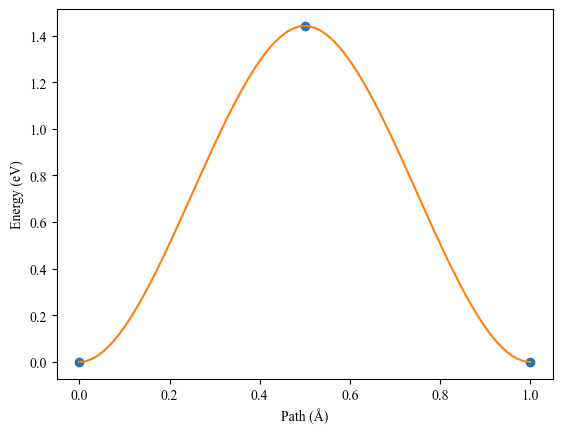

In [36]:
neb_copy_path = join(mdpath, 'Pt_neb_f_copy')
neb_md_models = get_dump_files(join(neb_copy_path,'results'))
neb_md_x, neb_md_e = get_md_neb_result(neb_copy_path)
neb_md_e = 0.042*neb_md_e

x_interp1, y_interp1 = interpolate_plot(neb_md_x, neb_md_e)

In [64]:
md_neb = join(neb_copy_path,'results')
is_model = read_lammps_onedata(md_neb, dump_fielname='dump.neb.1.text', format='lammps-dump-text')
ts_model = read_lammps_onedata(md_neb, dump_fielname='dump.neb.2.text', format='lammps-dump-text')
fs_model = read_lammps_onedata(md_neb, dump_fielname='dump.neb.3.text', format='lammps-dump-text')

is_eigen_force = -extract_atoms_data(join(md_neb,'dump.force.1.xyz'), order=0)[:,5:] # 本征应力需要取负号
ts_eigen_force = -extract_atoms_data(join(md_neb,'dump.force.2.xyz'), order=0)[:,5:]
fs_eigen_force = -extract_atoms_data(join(md_neb,'dump.force.3.xyz'), order=0)[:,5:]

is_eigen_stress = extract_atoms_data(join(md_neb,'dump.stress.1.xyz'), order=0)[:,5:]
ts_eigen_stress = extract_atoms_data(join(md_neb,'dump.stress.2.xyz'), order=0)[:,5:]
fs_eigen_stress = extract_atoms_data(join(md_neb,'dump.stress.3.xyz'), order=0)[:,5:]

is_eigen_force_field = covert6to3d(is_eigen_force)
ts_eigen_force_field = covert6to3d(ts_eigen_force)
fs_eigen_force_field = covert6to3d(fs_eigen_force)

is_eigen_stress_field = covert6to3d(is_eigen_stress)*0.1 # bar to MPa
ts_eigen_stress_field = covert6to3d(ts_eigen_stress)*0.1
fs_eigen_stress_field = covert6to3d(fs_eigen_stress)*0.1

is_force = -extract_atoms_data(join(md_neb,'dump.force.1.xyz'))[:,5:]
ts_force = -extract_atoms_data(join(md_neb,'dump.force.2.xyz'))[:,5:]
fs_force = -extract_atoms_data(join(md_neb,'dump.force.3.xyz'))[:,5:]
is_stress = -extract_atoms_data(join(md_neb,'dump.stress.1.xyz'))[:,5:]
ts_stress = -extract_atoms_data(join(md_neb,'dump.stress.2.xyz'))[:,5:]
fs_stress = -extract_atoms_data(join(md_neb,'dump.stress.3.xyz'))[:,5:]

is_force_field = covert6to3d(is_force)
ts_force_field = covert6to3d(ts_force)
fs_force_field = covert6to3d(fs_force)

is_stress_field = covert6to3d(is_stress)*0.1
ts_stress_field = covert6to3d(ts_stress)*0.1
fs_stress_field = covert6to3d(fs_stress)*0.1

print(is_eigen_force_field[-1])
print(ts_eigen_force_field[-1])
print(fs_eigen_force_field[-1])


[[ 2.61798e+04  9.12062e-01  2.46342e+03]
 [ 9.12062e-01  2.61799e+04  2.30932e+03]
 [ 2.46342e+03  2.30932e+03 -2.35920e+04]]
[[-4.57394e+06  3.78854e+00  3.15072e+03]
 [ 3.78854e+00  4.12578e+06  2.70655e+04]
 [ 3.15072e+03  2.70655e+04  7.45628e+06]]
[[ 2.61798e+04  8.57148e-01  2.31510e+03]
 [ 8.57148e-01  2.61798e+04  2.30932e+03]
 [ 2.31510e+03  2.30932e+03 -2.35922e+04]]


$\sigma _{xx}$
$\sigma _{yy}$
$\sigma _{zz}$


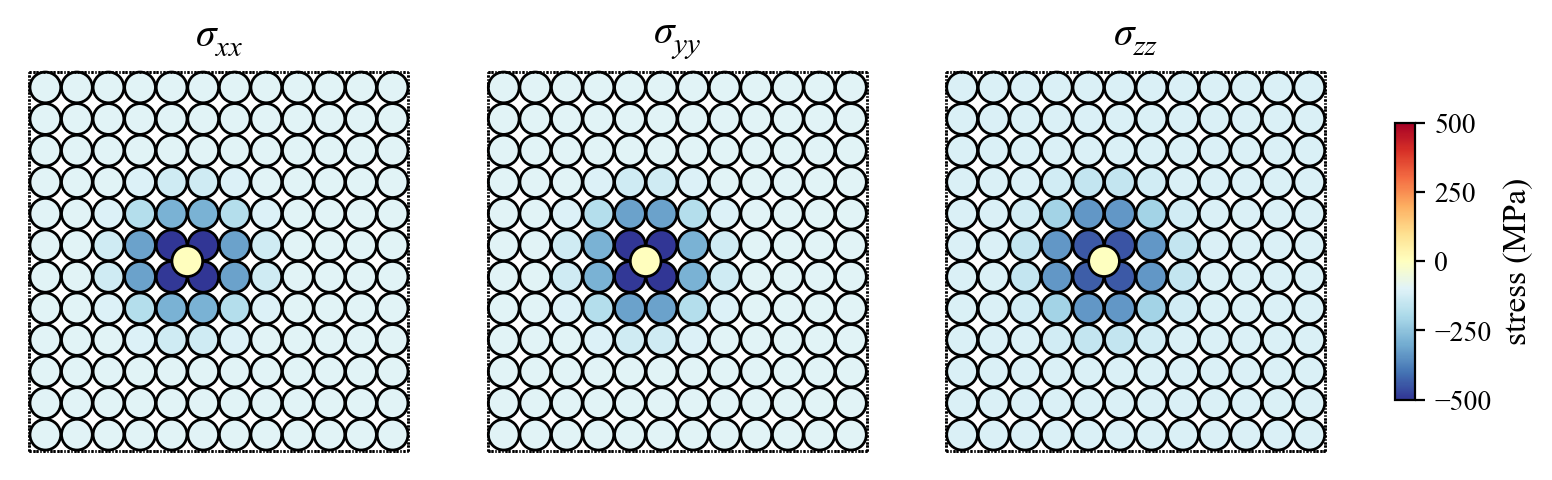

In [65]:
visiual_atoms_strain_3d(Pt_ads1, is_eigen_stress_field, input_range=[-5E2, 5E2], type='stress', units='MPa',layers=2)

$\sigma _{xx}$
$\sigma _{yy}$
$\sigma _{zz}$


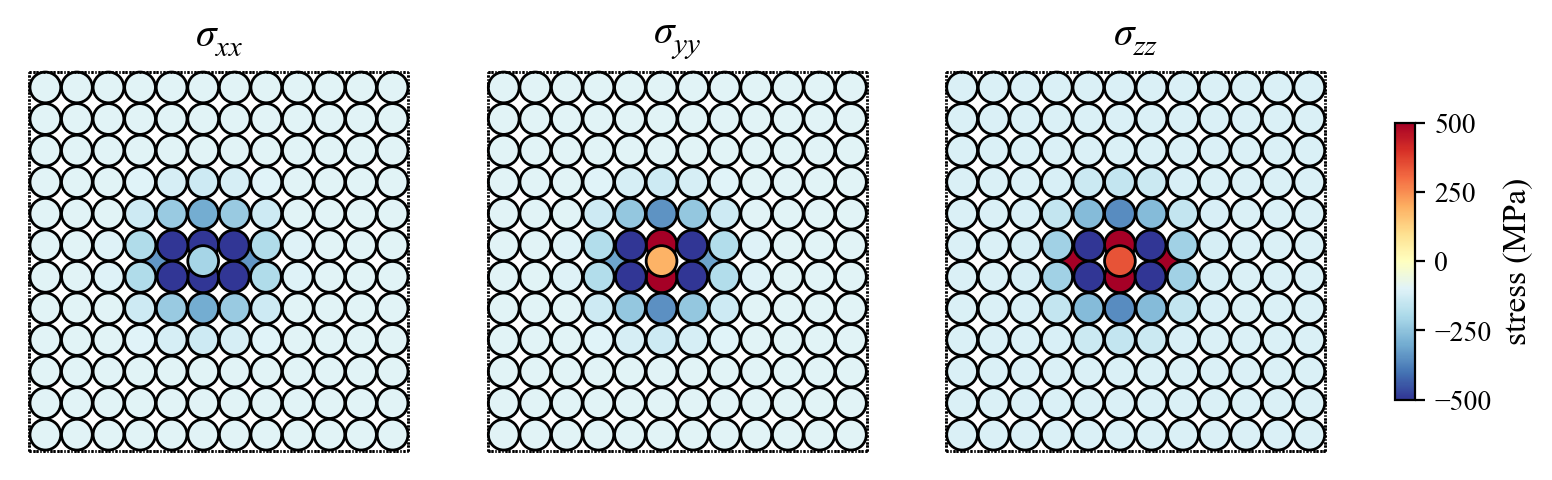

In [66]:
visiual_atoms_strain_3d(ts_model, ts_eigen_stress_field, input_range=[-5E2, 5E2], type='stress', units='MPa',layers=10)

$W _{xx}$
$W _{yy}$
$W _{zz}$


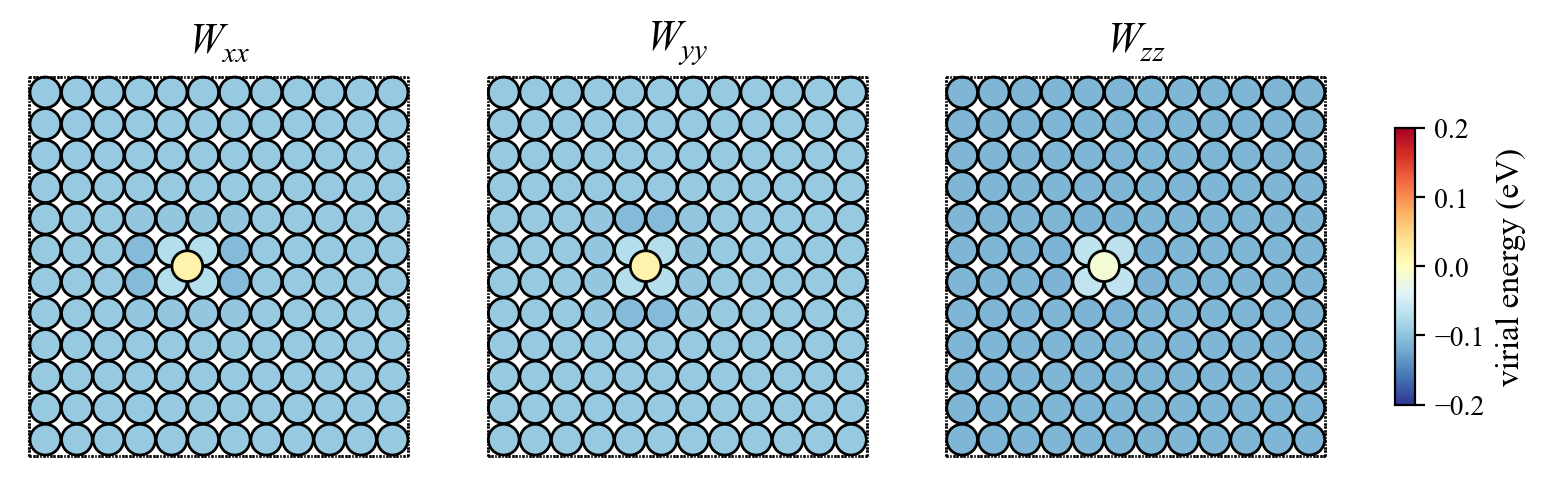

In [67]:
visiual_atoms_strain_3d(Pt_ads1, is_eigen_force_field*6.32421e-7, input_range=[-2e-1, 2e-1], type='virial energy', units='eV',layers=2)

$W _{xx}$
$W _{yy}$
$W _{zz}$


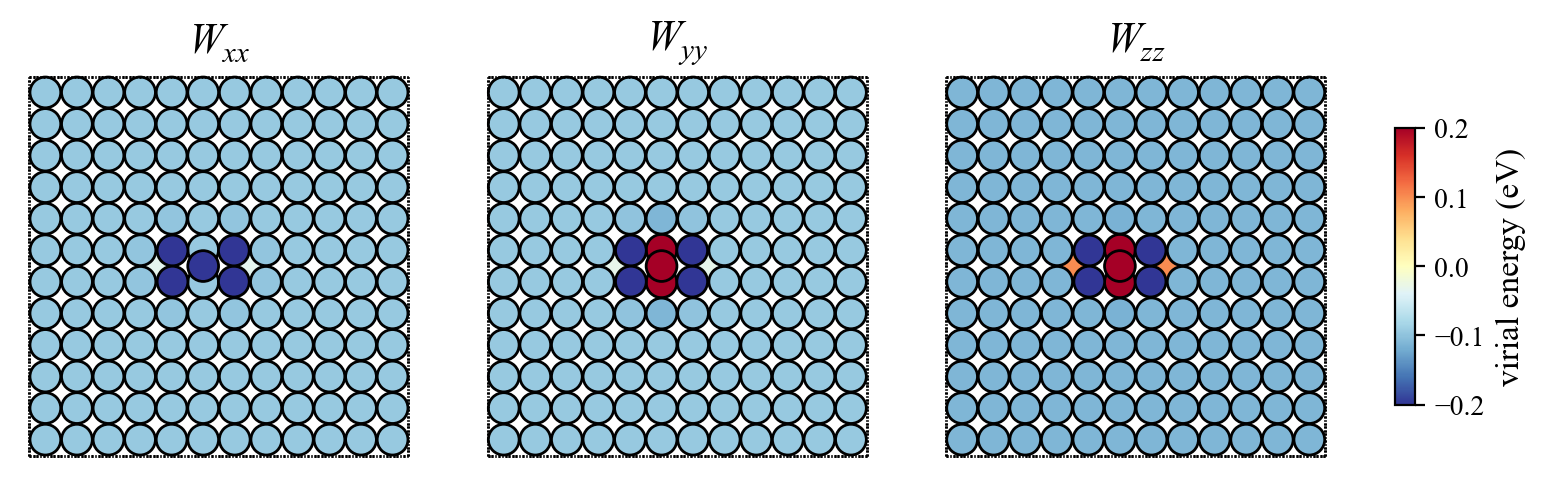

In [68]:
visiual_atoms_strain_3d(ts_model, ts_eigen_force_field*6.32421e-7, input_range=[-2e-1, 2e-1], type='virial energy', units='eV',layers=10)

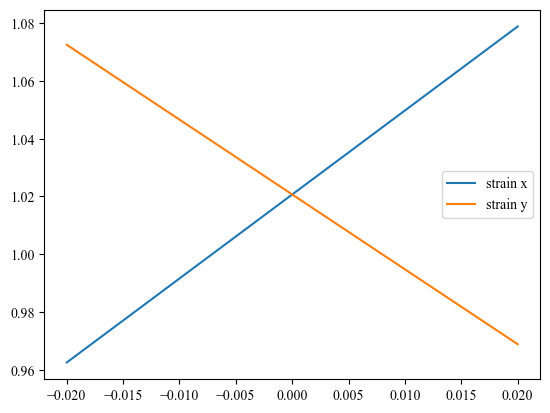

In [69]:
# 初态的本征应力，和过渡态的本征应力, 已经乘了夹杂体积
is_x = is_eigen_force_field[-1:, 0, 0]
is_y = is_eigen_force_field[-1:, 1, 1]

ts_x = ts_eigen_force_field[-1:, 0, 0]
ts_y = ts_eigen_force_field[-1:, 1, 1]

x_predict = np.array([-(ts_x - is_x) *max_strain *6.32421e-7 *i for i in range(-1,2)]) + max(neb_e0_l)
y_predict = np.array([-(ts_y - is_y) *max_strain *6.32421e-7 *i for i in range(-1,2)]) + max(neb_e0_l)

plt.figure()
plt.plot(np.arange(-1,2)*max_strain,x_predict, label='strain x')
plt.plot(np.arange(-1,2)*max_strain,y_predict, label='strain y')
plt.legend()
plt.show()

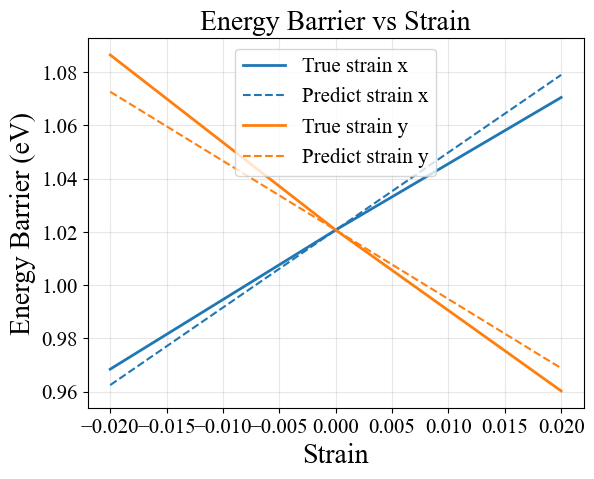

In [ ]:
predict_dict = {'x':x_predict,'y':y_predict,}

plt.figure()
for key, value in E_neb.items():
    plt.plot(value[:,0],value[:,1],linewidth = 2,
             label=f'True strain {key}')  # 根据实际情况修改标签
    color = plt.gca().get_lines()[-1].get_color()
    plt.plot(value[:,0],predict_dict[key], color=color,label=f'Predict strain {key}',linestyle='--' )
plt.xlabel('Strain', fontsize=20)
plt.ylabel('Energy Barrier (eV)', fontsize=20)
plt.title('Energy Barrier vs Strain', fontsize=20)
plt.grid(True, alpha=0.3)
plt.legend(loc='upper center',fontsize=15)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)

# plt.tight_layout()
# plt.legend()
plt.show()

# Conclusion

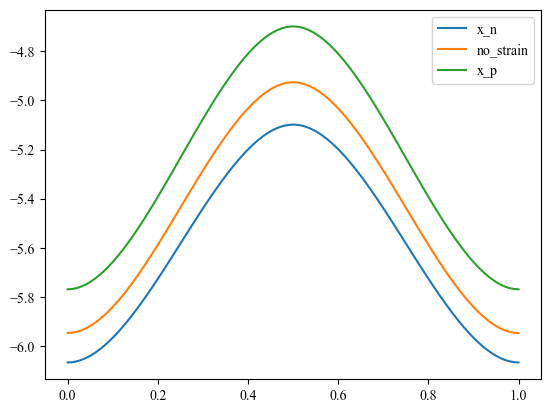

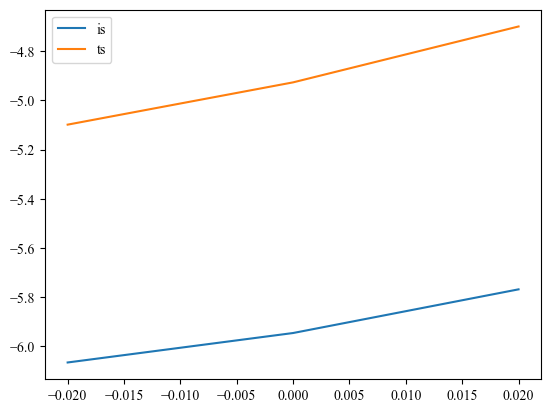

In [71]:
# plot_neb_energy
keys = ['x_n','no_strain','x_p']
neb_part = {key: all_neb[key] for key in keys}
plt.figure()
for key, value in neb_part.items():
    x = value.path_points
    e = value.energy_values
    x, e = interpolate_plot(x, e, is_plot=False)
    plt.plot(x, e, label=key)
plt.legend()
plt.show()

neb_data_list = []
for key, x_e in neb_part.items():
    # 创建基础字典
    entry = {
        'direction': x_e.name,
        'strain': sum(x_e.strain),
        'is_barrier': x_e.get_is_barrier(),
        'fs_barrier': x_e.get_fs_barrier()
    }
    # 添加能量值为单独列
    for i, energy_value in enumerate(x_e.energy_values):
        entry[f'energy_{i}'] = energy_value
    neb_data_list.append(entry)
neb_df = pd.DataFrame(neb_data_list)# 从列表直接创建DataFrame

plt.figure()
plt.plot(max_strain*np.arange(-1, 2), neb_df['energy_0'], label='is')
plt.plot(max_strain*np.arange(-1, 2), neb_df['energy_1'], label='ts')
plt.legend()
plt.show()


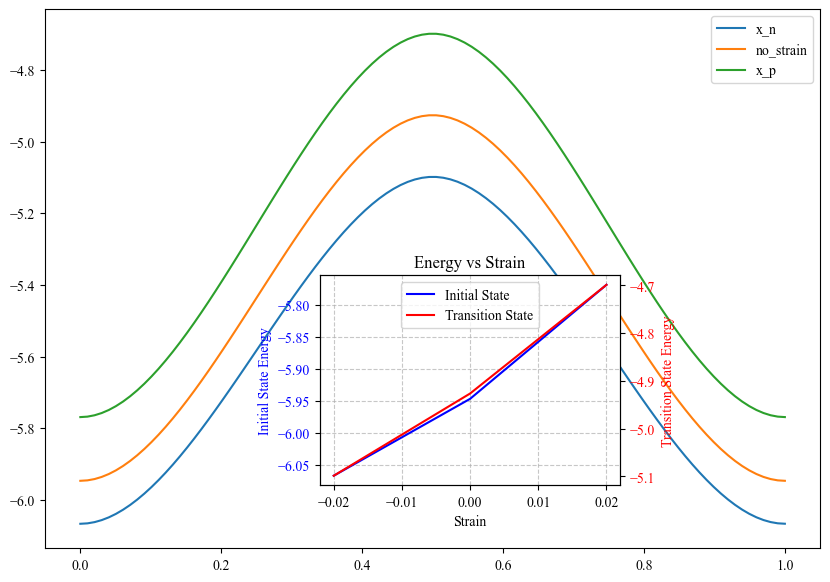

In [72]:
# 创建主图（第一幅图）
fig = plt.figure(figsize=(10, 7))  # 设置主图大小
ax_main = plt.subplot(111)  # 主图轴

# 绘制主图内容
neb_part = {key: all_neb[key] for key in keys}
for key, value in neb_part.items():
    x = value.path_points
    e = value.energy_values
    x, e = interpolate_plot(x, e, is_plot=False)
    ax_main.plot(x, e, label=key)
ax_main.legend()

# 创建插入子图（第二幅图 - 双y轴）
ax_inset = fig.add_axes([0.4, 0.2, 0.3, 0.3])  # [左, 下, 宽, 高] 相对位置
ax_left = ax_inset  # 左轴
ax_right = ax_inset.twinx()  # 创建右轴（共享x轴）

# 准备数据
neb_data_list = []
for key, x_e in neb_part.items():
    entry = {
        'direction': x_e.name,
        'strain': sum(x_e.strain),
        'is_barrier': x_e.get_is_barrier(),
        'fs_barrier': x_e.get_fs_barrier()
    }
    for i, energy_value in enumerate(x_e.energy_values):
        entry[f'energy_{i}'] = energy_value
    neb_data_list.append(entry)
neb_df = pd.DataFrame(neb_data_list)

# 计算最大应变（如果未定义）
if 'max_strain' not in locals():
    max_strain = max(neb_df['strain'].abs().max(), 1e-6)  # 避免为0

# 在左轴绘制初始能量 (energy_0)
line1, = ax_left.plot(max_strain * np.arange(-1, 2), neb_df['energy_0'],
                    'b-', label='Initial State')
ax_left.set_ylabel('Initial State Energy', color='b')
ax_left.tick_params(axis='y', labelcolor='b')

# 在右轴绘制过渡态能量 (energy_1)
line2, = ax_right.plot(max_strain * np.arange(-1, 2), neb_df['energy_1'],
                     'r-', label='Transition State')
ax_right.set_ylabel('Transition State Energy', color='r')
ax_right.tick_params(axis='y', labelcolor='r')

# 设置子图标题和标签
ax_inset.set_xlabel('Strain')
ax_inset.set_title('Energy vs Strain')
ax_inset.grid(True, linestyle='--', alpha=0.7)

# 合并图例
lines = [line1, line2]
labels = [line.get_label() for line in lines]
ax_inset.legend(lines, labels, loc='upper center')

plt.show()

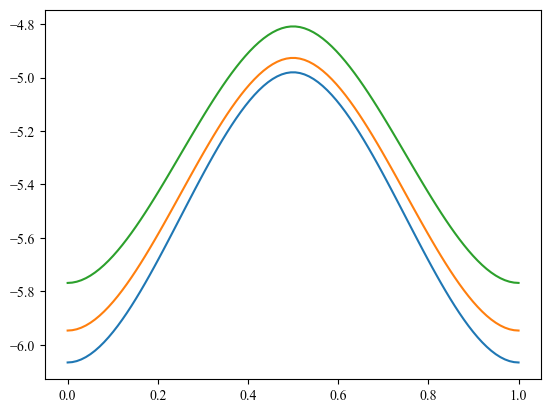

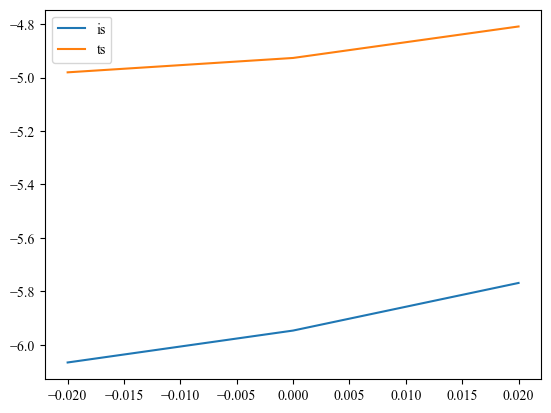

In [73]:
# plot_neb_energy
keys = ['y_n','no_strain','y_p']
neb_part = {key: all_neb[key] for key in keys}
plt.figure()
for key, value in neb_part.items():
    x = value.path_points
    e = value.energy_values
    x, e = interpolate_plot(x, e, is_plot=False)
    plt.plot(x, e)
plt.show()

neb_data_list = []
for key, x_e in neb_part.items():
    # 创建基础字典
    entry = {
        'direction': x_e.name,
        'strain': sum(x_e.strain),
        'is_barrier': x_e.get_is_barrier(),
        'fs_barrier': x_e.get_fs_barrier()
    }
    # 添加能量值为单独列
    for i, energy_value in enumerate(x_e.energy_values):
        entry[f'energy_{i}'] = energy_value
    neb_data_list.append(entry)
neb_df = pd.DataFrame(neb_data_list)# 从列表直接创建DataFrame

plt.figure()
plt.plot(max_strain*np.arange(-1, 2), neb_df['energy_0'], label='is')
plt.plot(max_strain*np.arange(-1, 2), neb_df['energy_1'], label='ts')
plt.legend()
plt.show()


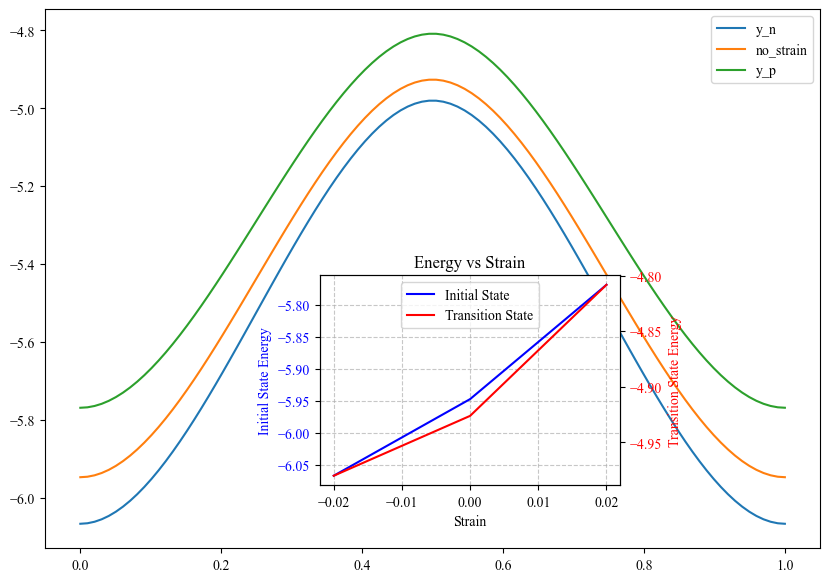

In [74]:
# 创建主图（第一幅图）
fig = plt.figure(figsize=(10, 7))  # 设置主图大小
ax_main = plt.subplot(111)  # 主图轴

# 绘制主图内容
neb_part = {key: all_neb[key] for key in keys}
for key, value in neb_part.items():
    x = value.path_points
    e = value.energy_values
    x, e = interpolate_plot(x, e, is_plot=False)
    ax_main.plot(x, e, label=key)
ax_main.legend()

# 创建插入子图（第二幅图 - 双y轴）
ax_inset = fig.add_axes([0.4, 0.2, 0.3, 0.3])  # [左, 下, 宽, 高] 相对位置
ax_left = ax_inset  # 左轴
ax_right = ax_inset.twinx()  # 创建右轴（共享x轴）

# 准备数据
neb_data_list = []
for key, x_e in neb_part.items():
    entry = {
        'direction': x_e.name,
        'strain': sum(x_e.strain),
        'is_barrier': x_e.get_is_barrier(),
        'fs_barrier': x_e.get_fs_barrier()
    }
    for i, energy_value in enumerate(x_e.energy_values):
        entry[f'energy_{i}'] = energy_value
    neb_data_list.append(entry)
neb_df = pd.DataFrame(neb_data_list)

# 计算最大应变（如果未定义）
if 'max_strain' not in locals():
    max_strain = max(neb_df['strain'].abs().max(), 1e-6)  # 避免为0

# 在左轴绘制初始能量 (energy_0)
line1, = ax_left.plot(max_strain * np.arange(-1, 2), neb_df['energy_0'],
                    'b-', label='Initial State')
ax_left.set_ylabel('Initial State Energy', color='b')
ax_left.tick_params(axis='y', labelcolor='b')

# 在右轴绘制过渡态能量 (energy_1)
line2, = ax_right.plot(max_strain * np.arange(-1, 2), neb_df['energy_1'],
                     'r-', label='Transition State')
ax_right.set_ylabel('Transition State Energy', color='r')
ax_right.tick_params(axis='y', labelcolor='r')

# 设置子图标题和标签
ax_inset.set_xlabel('Strain')
ax_inset.set_title('Energy vs Strain')
ax_inset.grid(True, linestyle='--', alpha=0.7)

# 合并图例
lines = [line1, line2]
labels = [line.get_label() for line in lines]
ax_inset.legend(lines, labels, loc='upper center')

plt.show()